# TED Talks 
## Analyzing what makes a TED Talk successful 

### Purpose 
TED Talks are popular and insightful, but not all TED talks are equal. Some get tens of thousands of more views than others, so we hope to look into what makes a TED Talk popular. We will look at the tags, the key-words, the groups, and do some moral/sentiment analysis on a database of over 2,000 TED talks and transcripts. We will then search for patterns in our segmented data, and see if we can learn anything about what makes an idea spread and tick.

The end user should be able to get a high-level understanding from the website, but for more detailed understanding, going through this notebook would be required. 

### Data Source

The data was obtained from [data.world](https://data.world/owentemple/ted-talks-complete-list), and has been made open by the user `owntemple`. 

### General Outline 

#### Part 0: General Analysis. This is relevant for Project A, and provides basic stats (Part 3 of Project B)
1. Find the most popular tags. Are there similarities 
2. Cross-reference popular nodes with popular tags. Are there any overlaps? (Use top 10% for each) 
3. What is the distribution of tags? Power-law? Exponential? 
4. What is the distribution of view-coutns? 
5. If we plot publish-date with view count, do we see anything? 
6. Repeat with tags. Any changes? Whch tags change frequency over time? 
7. Are there any authors/speakers that frequently show up in the top lists?

### The following consist of Part 3 of Project B: The Bulk of the Analysis

#### Part 1: Tag Analysis  

1. Build a network of TED talks 
  - Two node types: 
     - `tag`: The tags associated with a TED talk
     - `talk`: The talks themselves. 
  - Each `tag` node will have a bi-directional link to `talk` nodes only
2. Build a network of tags 
  - For each tag `a_tag`, look at all of it's associated `talk` nodes
     - For each `talk` node, look at related tags, `b_tag` 
     - Connect `a_tag` to `b_tag` if no link exists 
     - If a link exists, add one to the edge weight from `a_tag` to `b_tag` 
     - due to the nature of this network, each link will be undirected.
3. Find communities of tags 
4. Find high-centrality tags 
5. Look at the popular nodes, and then look at their tags. Is there a relationship between tag centrality and node popularity 
6. Look at the popular nodes. Do their tags form communities? With what modularity 
   - Look up other community measures for this purpose
7. Calculate average sentiment for each tag community 
8. Is there a relationship between tag community sentiment and associated node popularities? (Only applicable if we find that popular nodes link to communities) 

#### Part 2: Transcript Analysis 

1. Calculate Sentiment Profiles for each transcript 
   - Calculate Total sentiment2
   - Calculate moving sentiment with frame-size = 100 words, derived from very unscientific online posts discussing paragraph length. The idea is that each paragraph contains a general topic, and this will help isolate the topic. The first two paragraphs in the book _Catcher in the Rye_ have 480 words, which yields 240 words/paragraph and is therefore not a bad measure.
2. Determine the underlying structures 
    - This will be done using SVD. 
2. Find the popular nodes. Compare Profiles 

### Discussion (Part 4) is at the end. 

# Part 0

In [1]:
# General Imports 

import numpy as np 
import networkx as nx 
import scipy as sp 
import sklearn as sk 
import nltk 
import matplotlib.pyplot as plt 
import seaborn as sn 
import pandas as pd 
import community #Use infomap later 
from collections import Counter
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


First, we must load the data. 

In [2]:
data = pd.read_csv('./owentemple-ted-talks-complete-list/data/ted_talks_by_id_plus_transcripts_and_liwc_and_mft_plus_views.csv')
data['views'] = data['views_as_of_06162017']
del data['views_as_of_06162017']

In [3]:
print(len(data))
data = data.drop(np.arange(0, len(data))[data['views'].isnull()], axis=0)
print(len(data))

2475
2474


In [4]:
#Convert date published to datetime 
data['date_published'] = pd.to_datetime(data['date_published'], format="%Y-%m-%d")
data['tags'] = data['tags'].str.lower()

### 0.1: Find the most popular tags 

In [5]:
#Get the tags 
tags = [] 
for tag in data['tags']: 
    tags += [k.strip() for k in tag.split(",")]

#Now, lets count them 
tag_count = Counter(tags)
sorted_tags = sorted(tag_count.items(), key=lambda x: x[1], reverse=True) 

#Let's display the top 5% 
print("There are", len(tag_count), "tags in total.")
sorted_tags[0:len(tag_count)//20]

There are 418 tags in total.


[('technology', 710),
 ('science', 541),
 ('global issues', 495),
 ('culture', 484),
 ('tedx', 432),
 ('design', 410),
 ('business', 341),
 ('entertainment', 298),
 ('health', 228),
 ('education', 218),
 ('innovation', 217),
 ('art', 207),
 ('society', 203),
 ('social change', 200),
 ('politics', 186),
 ('communication', 186),
 ('future', 182),
 ('biology', 181),
 ('creativity', 181),
 ('humanity', 169)]

At a quick glance, we can tell that STEM is the most popular topic. Manually grouping the top 5% (25 top) into 5 broad groups gives us: 

- Tech (technology, future)
- Science (science, biology, medicine, brain, health)
- Sociopolitical (global issues, TEDx, education, social change, society, environment, politics)
- Business: (business, innovation, commuincation, collaboration, economics)
- Humanity & Arts: (culture, design, entertainment, art, creativity, humanity)

These each have the totals shown below. 

In [6]:

tech = ['technology', 'future']
science = ['science', 'biology', 'medicine', 'brain', 'health']
sociopolitical = ['global issues', 'TEDx', 'education', 'social change', 'society', 'environment', 'politics'] 
business = ['business', 'innovation', 'communication', 'collaboration', 'economics']
humanity_arts = ['culture', 'design', 'entertainment', 'art', 'creativity', 'humanity']
print("Tech:\t\t", sum([tag_count[t] for t in tech]))
print("Science:\t", sum([tag_count[t] for t in science]))
print("Sociopolitical: ", sum([tag_count[t] for t in sociopolitical]))
print("Business:\t", sum([tag_count[t] for t in business]))
print("Humanity & Arts:", sum([tag_count[t] for t in humanity_arts]))

Tech:		 892
Science:	 1260
Sociopolitical:  1460
Business:	 1071
Humanity & Arts: 1749


Evidently, there are certain tags that are more popular than others. 

## 0.2: Cross-Reference popular nodes with popular tags 

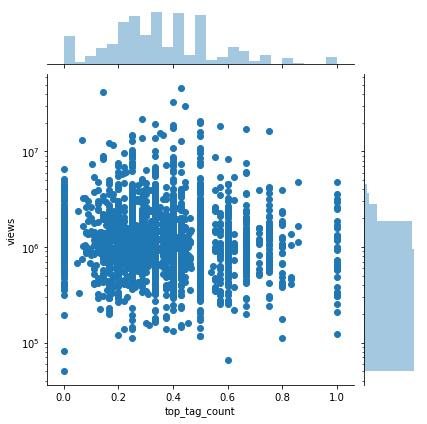

In [7]:
#First find the most popular nodes
top_tags = np.zeros((len(data),), dtype=float64) 
top_tag_set = set([k[0] for k in sorted_tags[0:len(sorted_tags)//20]])
for k, tag in enumerate(data['tags']): 
    tlist = set([k.strip() for k in tag.split(',')])
    #Adjust for some videos having several tags and others not
    top_tags[k] = len(tlist.intersection(top_tag_set))/len(tlist)
data['top_tag_count'] = top_tags
jointgrid = sn.jointplot(data['top_tag_count'], data['views'], kind='scatter', stat_func=None)
jointgrid.ax_joint.set_yscale('log')

We don't see any specially high view count for videos that are tagged in only the top 5% of tags. Let's see if the same thing happens for the bottom 5%: 

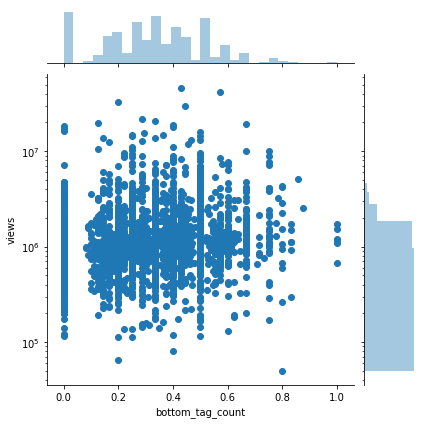

In [8]:
bottom_tags = np.zeros((len(data),), dtype=float64) 
bottom_tag_set = set([k[0] for k in sorted_tags[4*len(sorted_tags)//20:]])
for k, tag in enumerate(data['tags']): 
    tlist = set([k.strip() for k in tag.split(',')])
    #Adjust for some videos having several tags and others not
    bottom_tags[k] = len(tlist.intersection(bottom_tag_set))/len(tlist)
data['bottom_tag_count'] = bottom_tags
jointgrid = sn.jointplot(data['bottom_tag_count'], data['views'], kind='scatter', stat_func=None)
jointgrid.ax_joint.set_yscale('log')

Interestingly enough, there seems to be a slight right-skew, implying that its possible that higher views have a lesser proportion of specific/unique tags. However, this might just be due to the nature of the calculation. Since we're looking at the smallest number of tags, it's expected that some tags are found in very few videos, increasing the likelyhood of a video to be seen with few "bottom tags" 

While we're at it, let's just look at views and tag counts, and see if there's any obvious relationship between number of tags and views. 

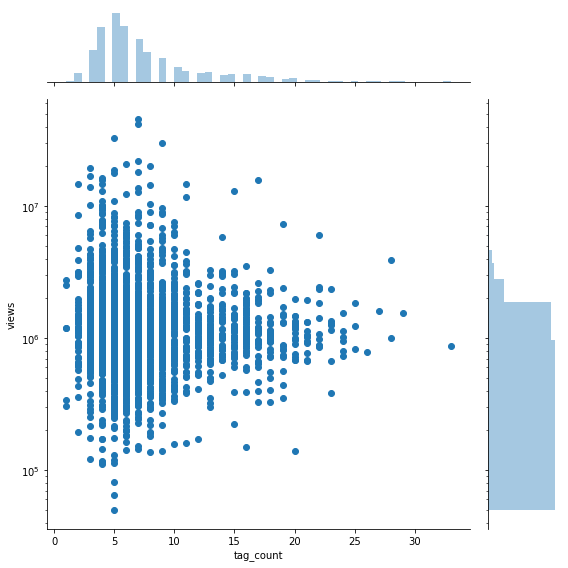

In [9]:
tag_count = np.zeros((len(data),), dtype=float64) 
tag_set = set([k[0] for k in sorted_tags])
for k, tag in enumerate(data['tags']): 
    tlist = set([k.strip() for k in tag.split(',')])
    #Adjust for some videos having several tags and others not
    tag_count[k] = len(tlist.intersection(tag_set))
data['tag_count'] = tag_count
jointgrid = sn.jointplot(data['tag_count'], data['views'], kind='scatter', stat_func=None)
jointgrid.ax_joint.set_yscale('log')
jointgrid.fig.set_size_inches(8, 8)
jointgrid.fig.tight_layout() 
jointgrid.fig.savefig("tag_count_views.png", dpi=300, bbox_inches="tight") 

In the log-plot, it seems as if there is a clear, if slight, increase in the base number of views as the tag count increases. However, the mean seems to stay the same. 

## 0.3 What is the distribution of tags

This is quite brief. Let's just see a KDE of tag counts 

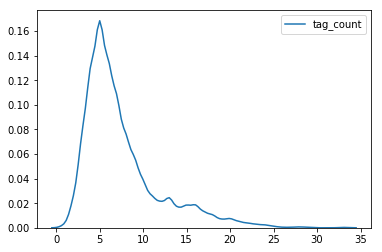

In [10]:
ax = sn.kdeplot(data['tag_count'], bw=.5)

Seems as if tag counts are normally distributed with a right-skew. It makes sense; most videos will have at least a few tags, which is where the peak is, and then it drops as fewer and fewer tags are applied.

## 0.4 What is the distribution fo view counts? 

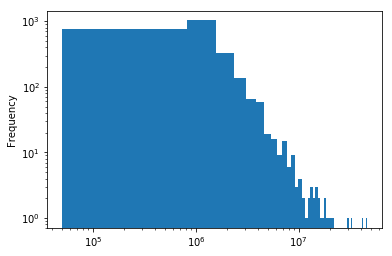

In [11]:
views = data['views']
views = views[~views.isnull()]
ax = views.plot.hist(bins=60)
ax.set_xscale('log')
ax.set_yscale('log')

Sometimes, a finely-tuned histogram yields more data than a KDEplot. There is a clear linear downward trend after an inital plateau, implying some sort of power-law view count 

## 0.5: Relationship between time and view-counts 

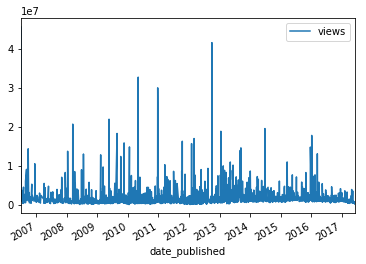

In [12]:
datetime = pd.DatetimeIndex(data['date_published'])
df = pd.DataFrame({"views": data['views'].values}, index=datetime)
df.plot()

Maybe a seven-day moving average will spread more light on it

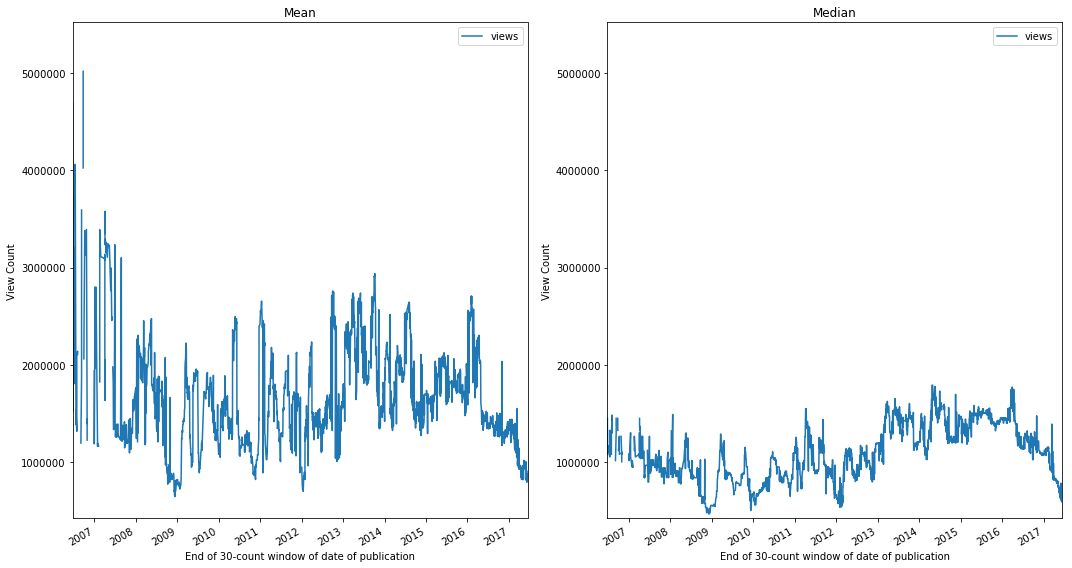

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8)) 
mean = df.rolling(window=30).mean()
median = df.rolling(window=30).median() 
mean.plot(ax=axs[0])
median.plot(ax=axs[1])
n = min(mean.min().tolist()[0], median.min().tolist()[0])
x = max(mean.max().tolist()[0], median.max().tolist()[0])
for ax in axs: 
    ax.set_ybound(n-n//10, x+x//10)
    ax.set_xlabel("End of 30-count window of date of publication")
    ax.set_ylabel("View Count") 
axs[0].set_title('Mean')
axs[1].set_title('Median')
fig.tight_layout()

It's interesting how the two tell a different story. The mean is hard to interpret, only the ending of it matches the ending of the median graph. The median graph, which is less prone to influence by outliers (i.e. extremely successful videos) shows a definite increase in view count in 2016, with a drop-off towards the present (perhaps due to fewer videos?) 

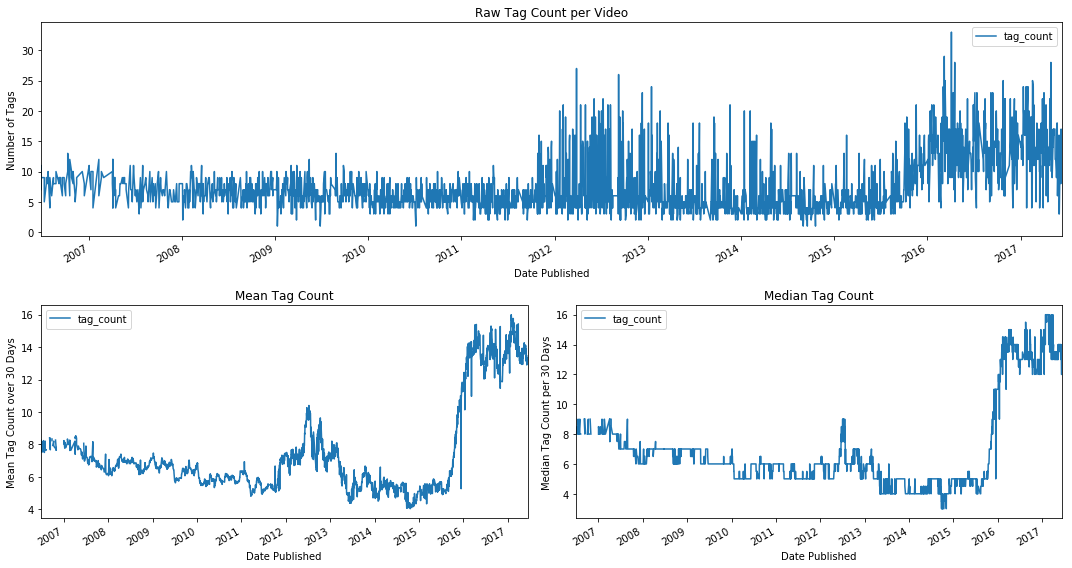

In [14]:
df['tag_count'] = data['tag_count'].values 
fig = plt.figure(figsize=(15, 8)) 
ax = plt.subplot(211)
df.plot(x=df.index, y='tag_count', ax=ax)
ax.set_title("Raw Tag Count per Video")
ax.set_xlabel("Date Published")
ax.set_ylabel("Number of Tags")

ax = plt.subplot(223) 
df.rolling(window=30).mean().plot(x=df.index, y='tag_count', ax=ax) 
ax.set_title("Mean Tag Count")
ax.set_xlabel("Date Published")
ax.set_ylabel("Mean Tag Count over 30 Days")

ax = plt.subplot(224) 
df.rolling(window=30).median().plot(x=df.index, y='tag_count', ax=ax) 
ax.set_ylabel("Median Tag Count per 30 Days")
ax.set_title("Median Tag Count")
ax.set_xlabel("Date Published")


fig.tight_layout()

Well, there's a clear pattern here. In recent years, the number of tags per video has clearly increased. 

### 0.5b) Which tags change frequency with time? 

Lets look at top_tag frequency by year 

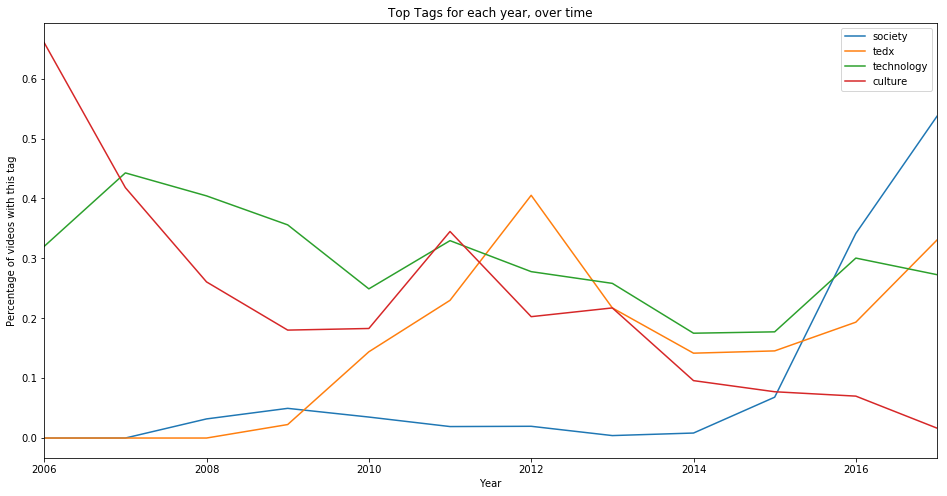

In [15]:
#We also need a count of how many videos were published in each year
year_count = Counter(pd.DatetimeIndex(data['date_published']).year)
yrs = dict((k, []) for k in year_count.keys())
for row in data.loc[:, ('tags', 'date_published')].values: 
    yrs[row[1].year] += [k.strip() for k in row[0].split(",")]

top_tags = set()
for year, tags in yrs.items(): 
    yrs[year] = Counter(tags)
    #Go through and extract the top 5 
    top_tags = top_tags.union(np.array(sorted(list(yrs[year].items()), key=lambda x: x[1], reverse=True)[0:1])[:, 0])

#now that we have the top tags, lets map their progression through time
time_progression = pd.DataFrame(index=list(yrs.keys()), columns=top_tags) 
for year, count in yrs.items():
    year_video_count = year_count[year] 
    for tag in time_progression.columns: 
        time_progression.loc[year, tag] = count[tag]/year_video_count 

#find the lower bound of each year's top 5 in percent 
# for year in time_progression.index: 
#     #find lower bound of top 5 
#     lower_bound = sorted(time_progression.loc[year].values, reverse=True)[4]
#     time_progression.loc[year][time_progression.loc[year] < lower_bound] = np.nan
        
time_progression = time_progression.sort_index()
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111) 
time_progression.plot(ax = ax)
ax.set_title("Top Tags for each year, over time")
ax.set_xlabel("Year") 
_ = ax.set_ylabel("Percentage of videos with this tag") 

It's interesting to see how the top tags per each year changed over time. We see that there are only four top tags over the last ten years, which in and of itself speaks volumes about our foci as a society. Speaking of society, the tag `society` starts off low, but suddenly rockets to the top of the chargs in the years after 2015. `Culture` simultaneously declines, as evidently people start to lose interest. `TEDx` rises as a tag, through the slow gain of TEDx in popularity instead of having only `TED` talks. (For the unaware, TEDx are local ted talks organized by communities instead of by the official TED organization). `Technology` is reliable; it is relatively constant throughout the lifespan of our dataset. 

## 0.7: Are there any really popular speakers? 

In [16]:
#Lets aggregate the number of videos each author occurs in
speakers = data.pivot_table(aggfunc=sum, index="speaker", values=("views",))
speaker_count = Counter(data['speaker'].values)
sc = pd.DataFrame(list(speaker_count.values()), index = list(speaker_count.keys()))
speakers = speakers.sort_index()
sc = sc.sort_index()
speakers['video_count'] = sc[0].values
del sc 
del speaker_count 
speakers['views_per_video'] = speakers['views'] / speakers['video_count']
print("Top 5 speakers by Views per Video")
print(speakers.sort_values('views_per_video', ascending=False)[0:5])
print("Top 5 speakers by Total Views")
print(speakers.sort_values('views', ascending=False)[0:5])
print("Top 5 speakers by Number of Videos")
print(speakers.sort_values('video_count', ascending=False)[0:5])

Top 5 speakers by Views per Video
                        views  video_count  views_per_video
speaker                                                    
Amy Cuddy          41505006.0            1       41505006.0
Mary Roach         21902550.0            1       21902550.0
Jill Bolte Taylor  20643201.0            1       20643201.0
Tony Robbins       19981744.0            1       19981744.0
Simon Sinek        38901229.0            2       19450614.5
Top 5 speakers by Total Views
                      views  video_count  views_per_video
speaker                                                  
Ken Robinson     60923649.0            4      15230912.25
Amy Cuddy        41505006.0            1      41505006.00
Simon Sinek      38901229.0            2      19450614.50
BrenÃ© Brown     37497319.0            2      18748659.50
Julian Treasure  28438682.0            5       5687736.40
Top 5 speakers by Number of Videos
                          views  video_count  views_per_video
speaker      

Wow. Ken Robinson. Maintaining 15,231,000 views per video for all his videos is quite impressive. Of course, reaching 41,500,000 views itself is quite a feat, one that Amy Cuddy achieved. She's quite a one-hit-wonder, being the only individual with one video reaching the top 5 total view count. 

# Part 1: Tag Network Analysis 

## 1.1 Building the Network

In [17]:
g = nx.Graph() 
print(len(data.index))
for row in data.index:
    try:
        title = data.loc[row, 'headline']
    except: 
        print(row)
    tags = [t.strip() for t in data.loc[row, 'tags'].split(',') if len(t.strip()) > 0]
    for tag in tags: 
        g.add_edge(title, tag, weight=1)
        g.nodes[tag]['class'] = 'tag'
    g.nodes[title]['class'] = 'talk'
    g.nodes[title]['id'] = row 

2474


Let's look at a few graph statistics to get an idea of what it's like. First, a picture. 

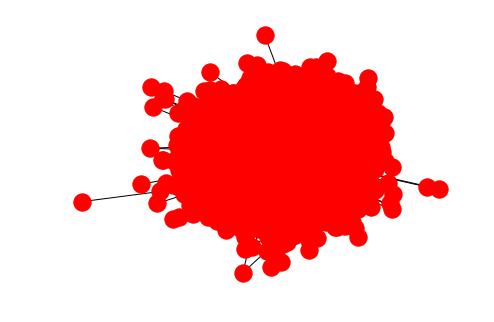

In [18]:
nx.draw(g) 

Let's get a look at other statistics of this graph: 

In [19]:
print("Total number of nodes:", len(g.nodes), "and edges:", len(g.edges)) 
print("Graph density: ", len(g.edges)/(len(g.nodes)*(len(g.nodes) - 1)/2))
print("Total number of talks:", len([1 for n in g.nodes if g.nodes[n]['class'] == 'talk']))
print("Total number of tags:", len([1 for n in g.nodes if g.nodes[n]['class'] == 'tag']))
print("Total number of components:", len([x for x in nx.connected_component_subgraphs(g)]))

Total number of nodes: 2891 and edges: 18512
Graph density:  0.004431363771829769
Total number of talks: 2474
Total number of tags: 417
Total number of components: 1


## 1.2: Building the tag network

In [20]:
tag_net = nx.Graph()

tag_nodes = [n for n in g.nodes if g.nodes[n]['class'] == 'tag']
for tag in tag_nodes: 
    #Grab neighbors of this tag. 
    talk_nodes = nx.neighbors(g, tag)
    for talk_node in talk_nodes: 
        #grab neighbors here 
        tag_neighbors = nx.neighbors(g, talk_node) 
        #link the tags 
        for tag_n in tag_neighbors: 
            if not tag_n == tag: 
                if (tag_n, tag) in tag_net.edges: 
                    tag_net[tag_n][tag]['weight'] += 1
                else: 
                    tag_net.add_edge(tag_n, tag, weight=1)

Some statistics:

In [21]:
print("Total number of nodes:", len(tag_net.nodes), "and edges:", len(tag_net.edges)) 
print("Graph density: ", len(tag_net.edges)/(len(tag_net.nodes)*(len(tag_net.nodes) - 1)/2))
print("Total number of components:", len([x for x in nx.connected_component_subgraphs(g)]))

Total number of nodes: 417 and edges: 21708
Graph density:  0.2502767017155506
Total number of components: 1


So this graph is relatively highly connected, with a density of 25%. It has more edges than the original network, which is to be expected since its linking every tag to every tag each of it's neighbors links to. The sum of weights is going to be even higher, but we need to divide by two since they'll all be even. 

In [22]:
cumsum = 0 
for edge in tag_net.edges(data=True): 
    w = edge[2]['weight']/2
    tag_net[edge[0]][edge[1]]['weight'] = w 
    cumsum += w 
print("Sum of total weights", cumsum) 

Sum of total weights 83905.0


## 1.3: Find Communities of Tags

Originally, I wanted to use the Infomap algorithm. Unfortunately it is not compatible with NetworkX2.0 - therefore, we'll use Louvian for now.

Modularity of Louvian communities: 0.22976228208865354


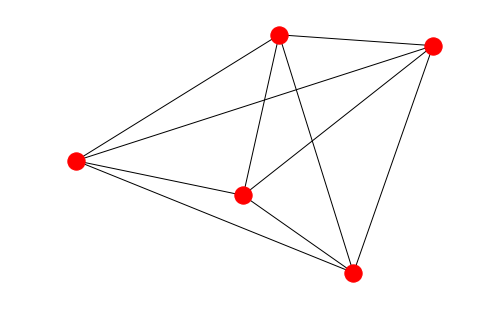

In [23]:
partitions = community.best_partition(tag_net, weight='weight')
viz = community.induced_graph(partitions, tag_net, weight='weight')
nx.draw(viz) 
print("Modularity of Louvian communities:", community.modularity(partitions, tag_net)) 

This implies sub-optimal communities, which is expected due to the high density of our graph. However the existence of communities is still supported; the interpretation is that the communities provide 23% higher density than the density of the graph; considering that our network is very dense to begin with, having such a significant increase in density is impressive. 

What are these partitions? Let's see... 

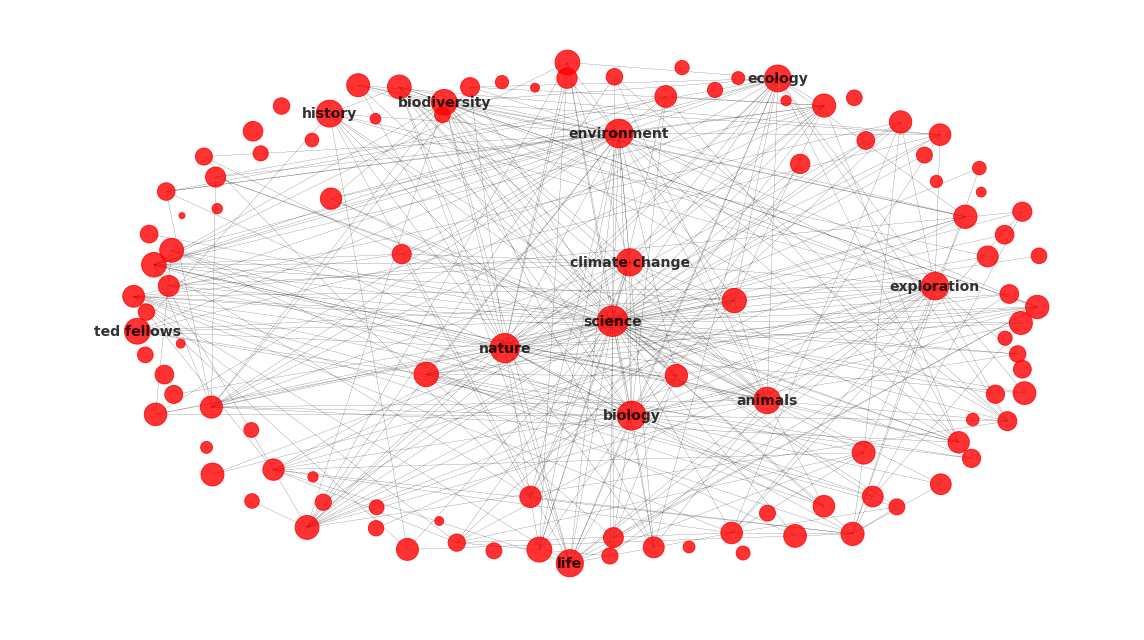

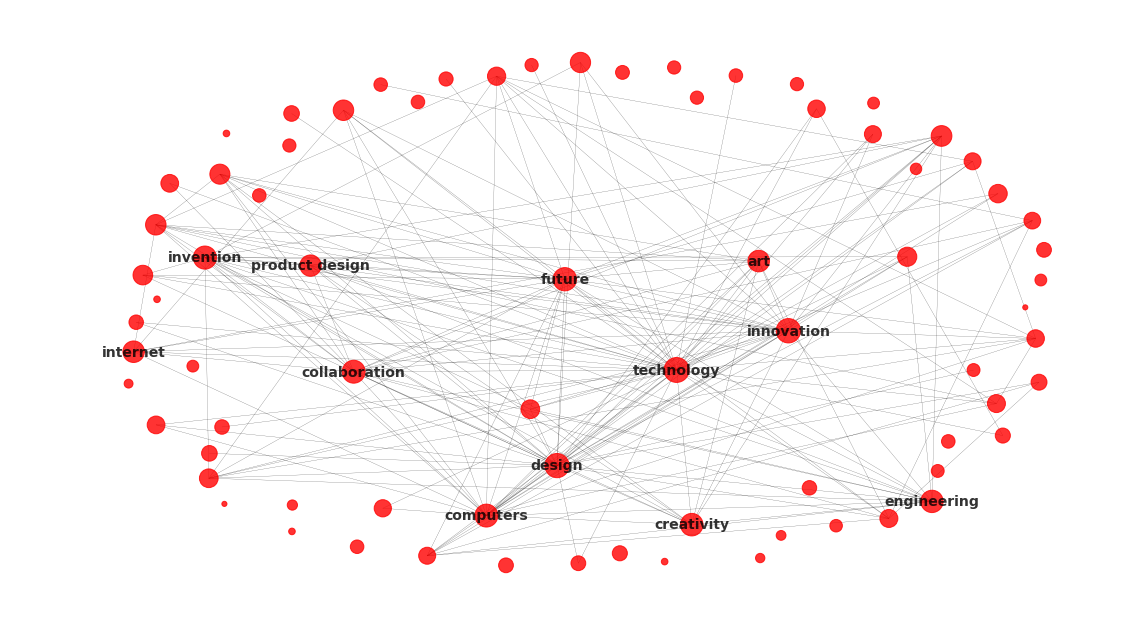

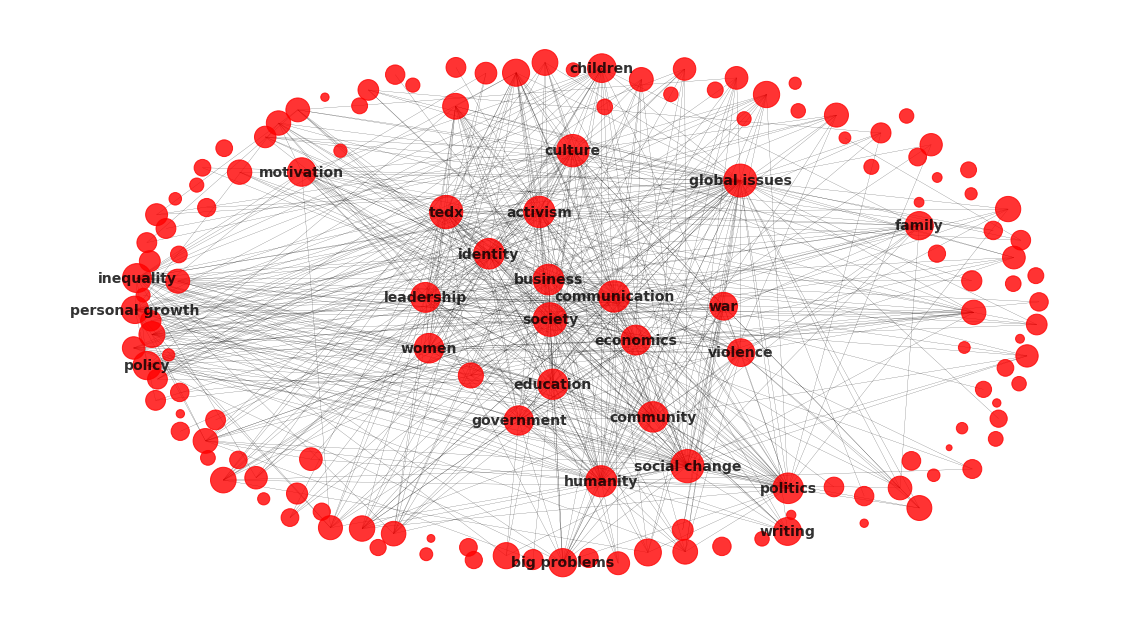

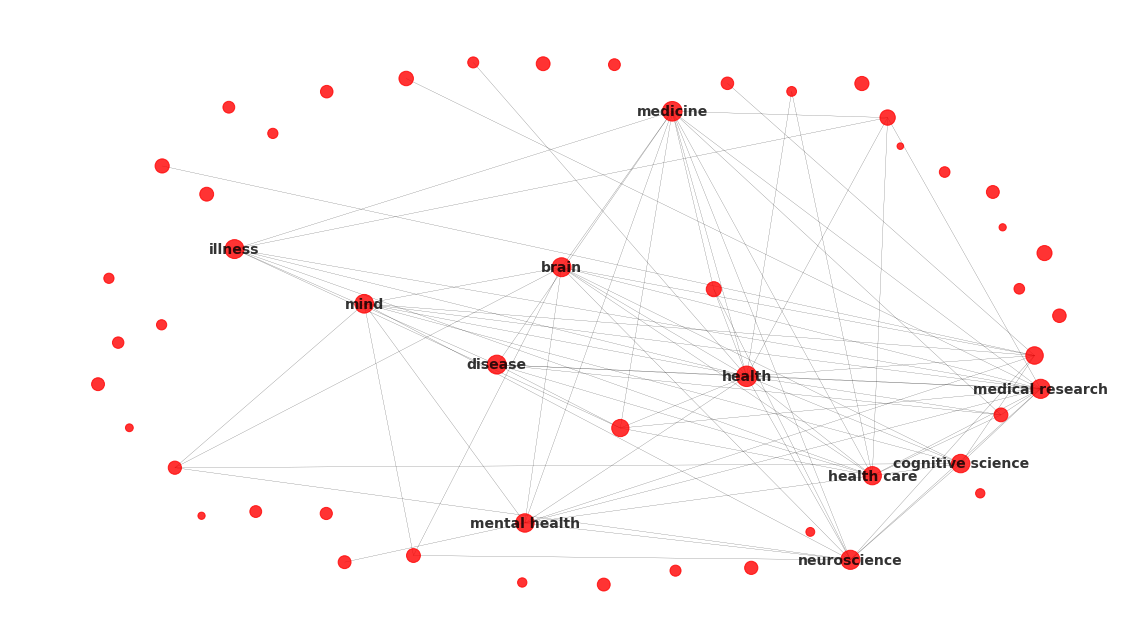

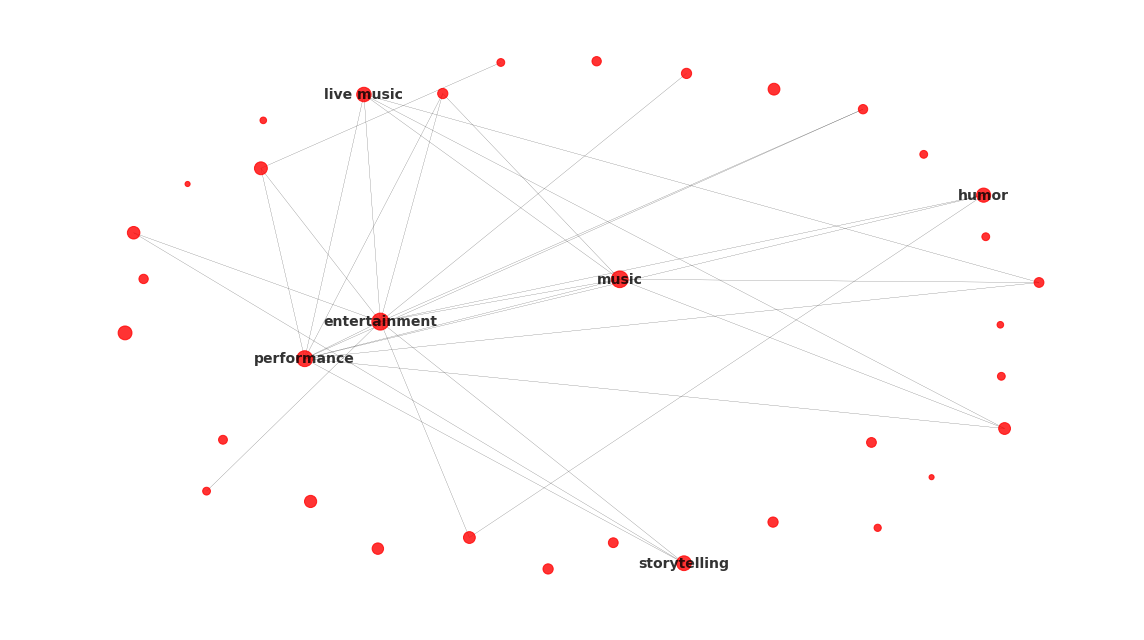

In [24]:
#Reverse the dictionary 
rev = {}
for n in viz.nodes: 
    rev[n] = []
for value, key in partitions.items(): 
    rev[key].append(value) 

#It's hard to visualize, so we'll build new graphs for each of these communities 
community_graphs = []
for v in rev.values(): 
    comm_g = tag_net.subgraph(v)
    degs = comm_g.degree()
    dd = np.array([(k[1]) for k in degs])
    edges = comm_g.edges(data=True)
    # Compute top percent of edges
    weights = np.zeros((len(edges),))
    for i, e in enumerate(edges): 
        weights[i] = e[2]['weight']
    #Weights will probably follow a power-law, but we can approx. 
    #with an exponential 
    exp_param = 1/np.mean(weights) 
    # Top x% of edges: .1 = e^(-lam x ) -> ln(.1)/(-lam) 
    CUTOFF = 0.2
    cutoff = np.log(CUTOFF)/-exp_param
    edgelist = [e for e in edges if e[2]['weight'] > cutoff]
    for el in edgelist: 
        comm_g[el[0]][el[1]]['nweight'] = 2 * np.log(el[2]['weight'])
    fig = plt.figure(figsize=(16, 9))  
    ax = plt.subplot(111) 
    deg_cutoff = np.log(CUTOFF)/(-1/np.mean(dd))
    top_nodes = list(filter(lambda x: True if x[1] > deg_cutoff else False, degs))

    nx.draw(comm_g, 
            node_size=8.75 * dd, 
            pos=nx.spring_layout(comm_g, weight='nweight', k=4.5), 
            edgelist=edgelist, 
            ax=ax, 
           labels = dict([(x[0], x[0]) for x in top_nodes]), 
           font_size = 14, 
           font_weight="heavy", 
           font_color = "black", 
           node_color = 'red', 
             width=0.2, 
           alpha=0.8)
    top_node = sorted(dict(degs).items(), key=lambda x: x[1], reverse=True)[0][0]
    fig.tight_layout()
    fig.savefig(top_node + "_network.png", dpi=300, bbox_inches="tight")
    #Find the top edges


All nodes are connected, but due to the sheer number of edges roughly the top 25% of edges are shown (top 25% cutoff estimated by an exponential distribution). Its fascinating how these tags are arranged; we have, in order of community: 

1. Sciences 
2. Technology, Design, and Innovation 
3. Global Issues 
4. Arts 
5. Medicine 

It's also interesting how the categories can be aptly named by the central members of the network. Earlier, we had tried manually creating communities based on top tags. Our tags were: 
1. Tech		
2. Science
3. Sociopolitical
4. Business
5. Humanity & Arts 

All in all, the only real change is the merging of "Business" and "Tech" in favor of spliting "Science" into "Medicine" and "Science" 

## 1.4 High-Centrality Tags

Now, let's take a global look at the high-centrality tags 

In [25]:
sorted(tag_net.degree(), key=lambda x: x[1], reverse=True)[0:10]

[('technology', 363),
 ('tedx', 356),
 ('science', 348),
 ('global issues', 329),
 ('innovation', 325),
 ('society', 312),
 ('culture', 306),
 ('future', 304),
 ('collaboration', 304),
 ('humanity', 301)]

These are (unsurprisingly) very similar to the tags found in the first section when we looked at total tag occurances. The spread is much smaller, however. 

Now, lets find the hubs. We are going to calculate the
betweenness centraliy of every tag. The significance in this case is that tags with a high betweenness centrality 
are the defining tags of subjects. 

In [26]:
tag_betweenness_centrality = nx.betweenness_centrality(tag_net) 
sorted(tag_betweenness_centrality.items(), key = lambda x: x[1], reverse=True)[0:10]

[('technology', 0.030411694813168553),
 ('tedx', 0.027452005746777624),
 ('science', 0.02577643832854708),
 ('culture', 0.021655304401017397),
 ('innovation', 0.020868832803947284),
 ('global issues', 0.020751690181590655),
 ('society', 0.017887598911682116),
 ('collaboration', 0.017773323716707267),
 ('social change', 0.014977580653703236),
 ('future', 0.014581379935774966)]

Interestingly enough, there are some differences! Technology is still the King, followed by tedx and science. Culture, The rest simply have their order mixed up, but there are not actually any different tags present. These top 10 tags seem to be the defining concepts of TED talks. 

## 1.5 Correlation between popular videos and high-centrality (popular) tags

There are several ways to attack this issue 
* For each video, take a look at each tag. Define each observation as `(video popularity, tag degree)` 
* For each video, take a look at each tag. Define each observation as `(video popularity, tag betweenness centrality)` 
* We know that each video $v_k$  has a view count $v_{k, i} $. That means, each tag $t \in v$ associated has been viewed that many times. Repeat the first method, but instead of using tag degree, define a tag's `influence` $t^{(i)}$ as, given $t_v$ being the set of videos associated with a certain tag, $$t^{(i)} := \sum_{v_i \in t_v} v_{i, k}$$ Then, each entry is $(v_{i, k}, t^{(i)})$ 

In [27]:
# Method one 
talks = [k for k in g.nodes(data=True) if k[1]['class'] == 'talk']
m1_size = sum(g.degree(k[0]) for k in talks)
#We can use the same array to save memory + speed stuff up. 
m12_o = np.zeros((m1_size, 4)) 
i = 0
for talk in talks:
    talk_n = talk[0]
    #Pull talk popularity 
    for tag in g.neighbors(talk_n): 
        m12_o[i, 0] = talk[1]['id']
        m12_o[i, 1] = data.loc[talk[1]['id'], 'views']
        #Pull tag degree 
        m12_o[i, 2] = tag_net.degree(tag) 
        #Pull centrality 
        m12_o[i, 3] = tag_betweenness_centrality[tag] 
        #Update tag influence score 
        if 'influence' in tag_net.nodes[tag]:
            tag_net.nodes[tag]['influence'] += m12_o[i, 0]
        else: 
            tag_net.nodes[tag]['influence'] = m12_o[i, 0] 
        i += 1 

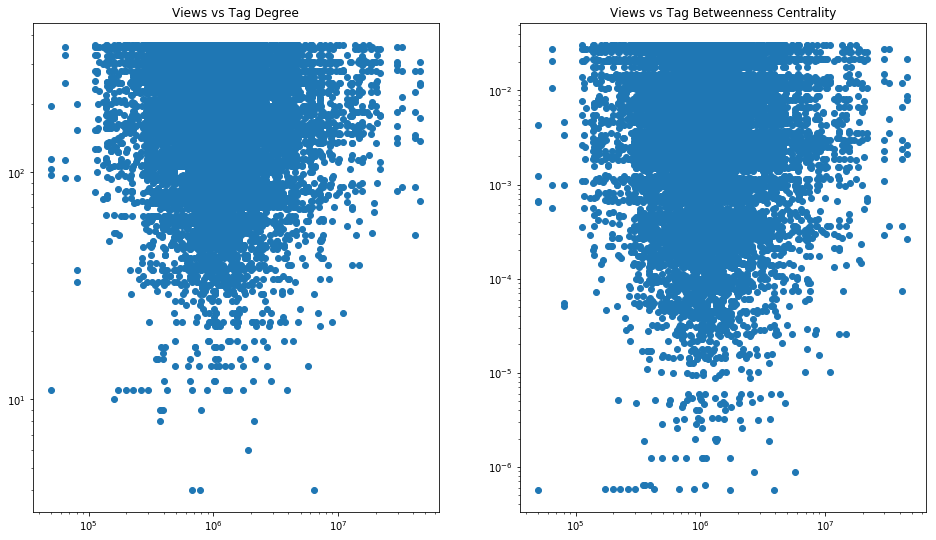

In [28]:
#Let's create a few scatterplots 
fig, axs = plt.subplots(1, 2, figsize=(16, 9)) 
axs[0].plot(m12_o[:, 1], m12_o[:, 2], 'o') 
axs[0].set_title("Views vs Tag Degree") 
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].plot(m12_o[:, 1], m12_o[:, 3], 'o') 
axs[1].set_title("Views vs Tag Betweenness Centrality")
axs[1].set_yscale('log')
axs[1].set_xscale('log')

Graphs don't tell us much... Maybe numbers will. 

In [29]:
np.corrcoef(m12_o[:,1:], rowvar=False)

array([[ 1.        , -0.0189416 , -0.01509623],
       [-0.0189416 ,  1.        ,  0.90682834],
       [-0.01509623,  0.90682834,  1.        ]])

There's a slight negative correlation, which is unexpected. 

In [30]:
m12_m = np.zeros((len(talks), 4))

for i, talk in enumerate(talks):
    talk_n = talk[0]
    m12_m[i, 0] = talk[1]['id']
    m12_m[i, 1] = data.loc[talk[1]['id'], 'views']
    tmp = [] 
    tmp2 = [] 
    for tag in g.neighbors(talk_n): 
        #Pull tag degree 
        tmp.append(tag_net.degree(tag))
        #Pull centrality 
        tmp2.append(tag_betweenness_centrality[tag])
    m12_m[i, 2] = np.mean(tmp) 
    m12_m[i, 3] = np.mean(tmp2) 

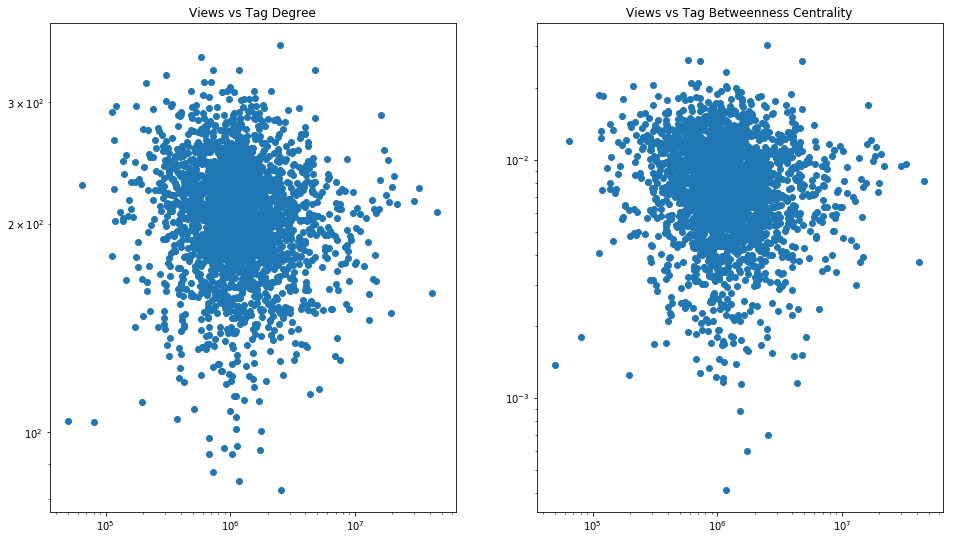

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9)) 
axs[0].plot(m12_m[:, 1], m12_m[:, 2], 'o') 
axs[0].set_title("Views vs Tag Degree") 
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].plot(m12_m[:, 1], m12_m[:, 3], 'o') 
axs[1].set_title("Views vs Tag Betweenness Centrality")
axs[1].set_yscale('log')
axs[1].set_xscale('log')

In [32]:
np.corrcoef(m12_m[:,1:], rowvar=False)

array([[ 1.        , -0.05651211, -0.04285298],
       [-0.05651211,  1.        ,  0.89650643],
       [-0.04285298,  0.89650643,  1.        ]])

Nope, nothing. 

## 1.6 Communities of Tags of High-View Videos 

Referencing [Gomez et al. 2009](http://deim.urv.cat/~alexandre.arenas/publicacions/pdf/signed.pdf) we don't have negative weights, so we don't need to split modularity; however, we can use the following 
> $$ \frac{1}{2w} \sum_{i} \sum_{j} \left( w_{ij} - \frac{w_iw_j}{2w}\right) \delta(C_i, C_j)$$ with $\delta(C_i, C_j)$ being the Kronecker delta function, with values of 0 if nodes $i$ and $j$ are in the same communitiy, and $0$ otherwise 

We'll use that to determine sub-community modularity as we expand over the top nodes. Instead of taking the sum over all the nodes, we'll take it over only nodes in a sub community. This will give us a measure of change in modularity as we expand. In effect, we're partitioning the graph into two communities: the top proportion, and the not top proportion, and measuring how the modularity changes as we move through these partitions. 

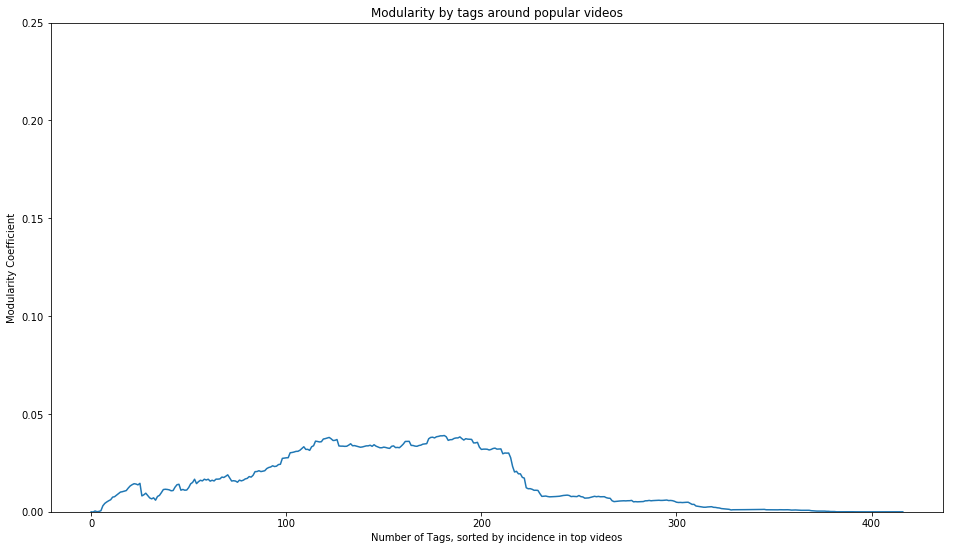

In [33]:
#Compute changing order of tags
#First get the sorted order of talks based on views
top_talks = data.loc[:, ("views", "headline")]
top_talks = top_talks.sort_values("views", ascending=False)
tag_order = {}
net_tags = set() 
for k, talk in enumerate(top_talks.iterrows()): 
    #get tags from this talk 
    ttags = g.neighbors(talk[1]['headline'])
    #convert to set 
    ttags = set(ttags) 
    #see which tags aren't in the net_tags 
    diff = ttags - net_tags 
    #set this equal to our dict 
    tag_order[k] = list(diff) 
    #update net tags 
    net_tags = net_tags.union(diff) 
#Generete list of tags 
tag_list = []
for k, v in tag_order.items(): 
    tag_list += v 

#Now we have our order of tags. Let's get a weighted matrix in this order  
wij = nx.adjacency_matrix(tag_net, nodelist=tag_list) 

#Now we can compute the wi*wj/2w matrix. We'll sum up the degrees of each tag, and then take a matrix product to 
#get the pairwise degree multiplication 
degs = wij.sum(axis=1) #it's symmetric, so axis doesn't matter 
two_w = degs.sum() #sum of all the weights returns 2w 
wiwj = (np.dot(degs, degs.T))/two_w 
ww = wij - wiwj 
wwm = ww.mean()
#Now the fun part. We'll go over the tags of each video and compute 
#the modularity over them. 
part_mod = lambda vect: ww[np.ix_(vect, vect)].sum().sum()/two_w
mod = lambda x: part_mod(np.arange(0, x)) + part_mod(np.arange(x, ww.shape[0]))
mod = np.vectorize(mod) 
mods = mod(np.arange(0, len(net_tags)))
fig = plt.figure(figsize=(16, 9)) 
ax = plt.subplot(111) 
ax.plot(np.arange(0, len(net_tags)), mods, label="Modularity") 
ax.set_ybound(0, .25) #up until computed modularity 
ax.set_title("Modularity by tags around popular videos") 
ax.set_ylabel("Modularity Coefficient")
ax.set_xlabel("Number of Tags, sorted by incidence in top videos")

There isn't much of an observable relationship. There is a definite, slight positive reach to the modularity, but by and large it is effectively 0; as in, **Top Tags do not form communities** Another way to interpret this is, with all the data we have seen, the top videos do not use the same tags, which implies, there isn't any clear video topic that is _always_ a hit.  

For rigor and good measure, let's take another approach. Let's look at the communities created by tags used ONLY by the top half of videos, and tags used ONLY by the bottom half of videos. 

In [34]:
split = len(top_talks)//2
top_half_talks = top_talks.iloc[0:split,:]['headline']
bottom_half_talks = top_talks.iloc[split:,:]['headline']
top_tagset = set() 
bottom_tagset = set() 
for t in top_half_talks: 
    top_tagset = top_tagset.union(set(g.neighbors(t))) 
for t in bottom_half_talks: 
    bottom_tagset = bottom_tagset.union(set(g.neighbors(t))) 
len(top_tagset), len(bottom_tagset)

(394, 405)

Confirmed, they both use only some of the tags. There is a difference of 10. 

In [35]:
both = top_tagset.intersection(bottom_tagset) 
len(both) 

382

So, what's different? 

In [36]:
only_top = list(top_tagset - both)
only_bottom = list(bottom_tagset - both)

My human brain categorizes the first one, the top tags, into "Tech" while the second one is more tangible and more liberal arts-y. Let's investigate if _these_ form communities. 

In [37]:
#Get the mapping of indicies 
ind_map = dict((k, i) for i, k in enumerate(tag_list))
quick_get = np.vectorize(ind_map.get)
map_vect = np.arange(0, ww.shape[0]) 
partial_mod = lambda vector: part_mod(vector) + part_mod(map_vect[np.in1d(map_vect, vector, invert=True)])
partial_mod(quick_get(only_top)), partial_mod(quick_get(only_bottom))

(1.7487023110607307e-05, -9.7814659749499677e-06)

so no, there isn't a community between these, either. 

## 1.7 Tag Sentiments 

In [38]:
#Load our Sentiment dataframe 
#The first three lines of the text file are unnecessary 
word_list = pd.read_csv('journal.pone.0026752.s001.TXT', delimiter='\t', skiprows=3)
#Convert the index to the words 
word_list.index = word_list['word'] 
del word_list['word']
#We only care about the happiness average, and perhaps happiness rank
word_list = word_list.iloc[:, 0:2]

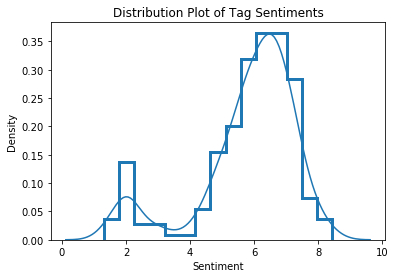

In [39]:
#For each tag, see if it's in the word list, and if it is, use it to make a plot of tag sentiments. 
ax = sn.distplot([word_list.loc[word, 'happiness_average'] for word in tag_set if word in word_list.index], 
           hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1})
ax.set_title("Distribution Plot of Tag Sentiments")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density")

Seems like overall, people prefer happy tags. There is a dramatic rise at 2, though, so there is a little tencency, not huge, for people to have negative tags. 

For good measure, lets look at the dist plots for top tags and bottom tags 

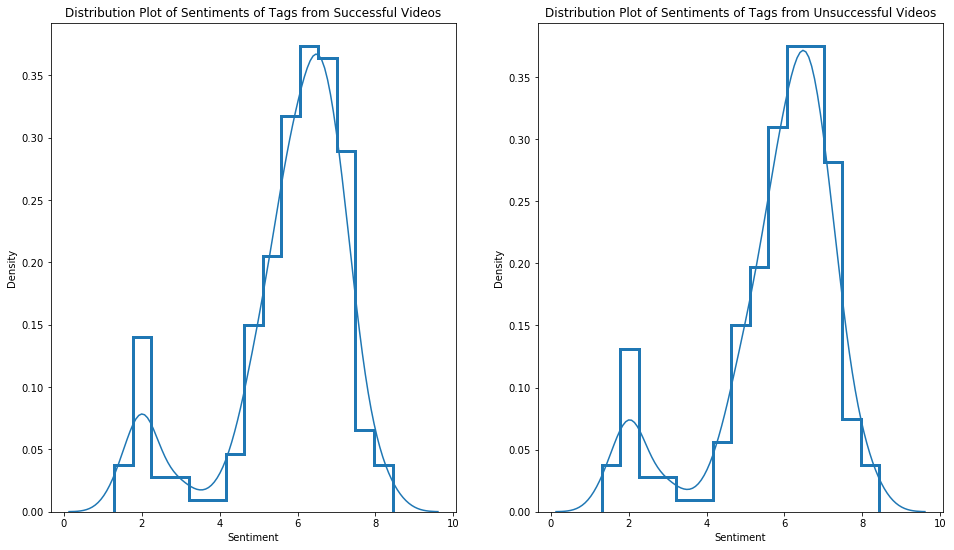

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9)) 
ax = axs[0] 
ax = sn.distplot([word_list.loc[word, 'happiness_average'] for word in top_tagset if word in word_list.index], 
           hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1}, ax=ax)
ax.set_title("Distribution Plot of Sentiments of Tags from Successful Videos")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density")
ax = axs[1] 
ax = sn.distplot([word_list.loc[word, 'happiness_average'] for word in bottom_tagset if word in word_list.index], 
           hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1}, ax=ax)
ax.set_title("Distribution Plot of Sentiments of Tags from Unsuccessful Videos")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density")

They follow the same distribution, implying that there isn't really a correlation between success and sentiment. In an extreme example, let's look at a smaller percentage of top and bottom videos. 

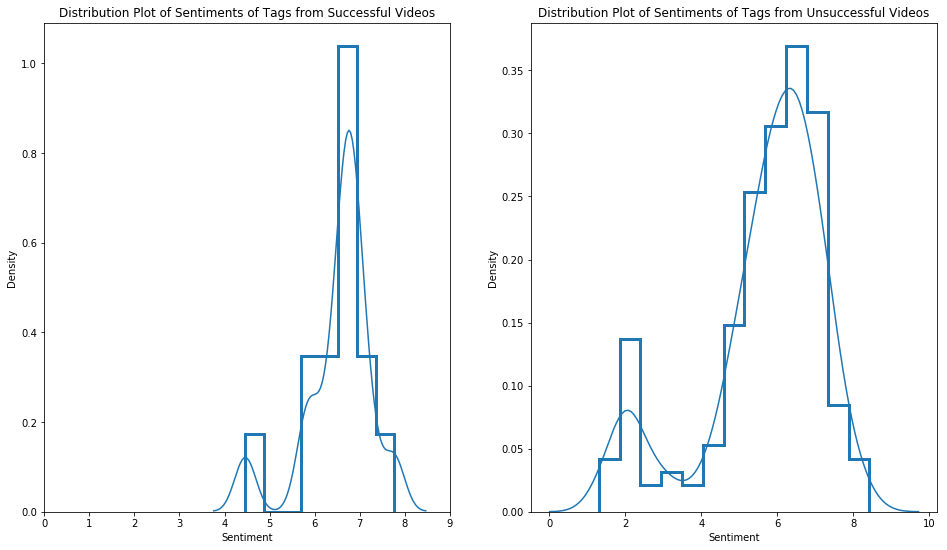

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9)) 
ax = axs[0] 
ax = sn.distplot([word_list.loc[word, 'happiness_average'] for word in top_tag_set if word in word_list.index], 
           hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1}, ax=ax)
ax.set_xbound(0, 9)
ax.set_title("Distribution Plot of Sentiments of Tags from Successful Videos")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density")
ax = axs[1] 
ax = sn.distplot([word_list.loc[word, 'happiness_average'] for word in bottom_tag_set if word in word_list.index], 
           hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1}, ax=ax)
ax.set_title("Distribution Plot of Sentiments of Tags from Unsuccessful Videos")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density")

There is now a clear difference. The scale for the top tags starts at 4; i.e. top tags are happier overall. 

### Sentiment in tag communities 

Community science has Mean Happiness of 6.21020833333 with STD 1.0369737412
Community technology has Mean Happiness of 6.24425 with STD 0.656813853006
Community society has Mean Happiness of 5.435 with STD 1.75903619444
Community health has Mean Happiness of 4.66739130435 with STD 2.01809255054
Community entertainment has Mean Happiness of 6.80130434783 with STD 0.668185761387


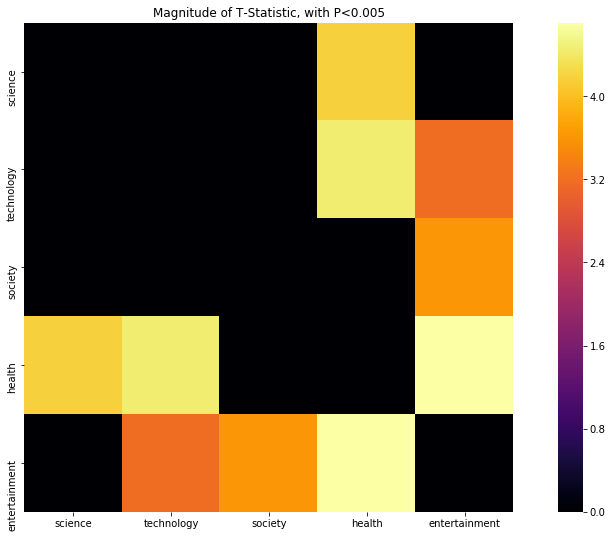

In [42]:
k = []
labels = [] 
for v in rev.values(): 
    comm_g = tag_net.subgraph(v)
    degs = dict(comm_g.degree())
    #Find top node to identify community by. 
    top_node = sorted(degs.items(), key=lambda x: x[1], reverse=True)[0][0]
    k.append([word_list.loc[word, 'happiness_average'] for word in v if word in word_list.index])
    labels.append(top_node) 
    print("Community",top_node, "has Mean Happiness of", np.mean(k[-1]), "with STD", np.std(k[-1]))
    
#calculate T-Test 
from scipy.stats import ttest_ind 
ts = np.zeros((5, 5))
ps = np.zeros((5, 5))
for i in range(0, 5):
    for j in range(0, 5): 
        t, p = ttest_ind(k[i], k[j]) 
        ts[i, j] = t
        ps[i, j] = p 

fig = plt.figure(figsize=(16, 9)) 
# ax = plt.subplot(121) 
# ax.set_title("T-Statistic Values") 
# sn.heatmap(ts, ax=ax, xticklabels = labels, yticklabels= labels, square=True)
# ax = plt.subplot(122)
# ax.set_title("P-Values") 
# sn.heatmap(ps, ax=ax, xticklabels = labels, yticklabels = labels, square=True) 
#Calculate Net values 
mask = ps < .005
ts[~mask] = 0 #above p-value indicates no evidence for difference. 
ax = sn.heatmap(np.abs(ts), square=True,xticklabels = labels, yticklabels = labels, cmap="inferno")
ax.set_title("Magnitude of T-Statistic, with P<0.005")

Naturally, health, the most depressing of topics, has the lowest happiness, while the most "frivolous", entertainment, has the most. Let's see if there is a discrepency.

# Part 2: Sentiment 

Citations for this segment 

Story Analysis 
> A. J. Reagan, L. Mitchell, D. Kiley, C. M. Danforth, and P. S. Dodds. The emotional arcs of stories are dominated by six basic shapes. EPJ Data Science, 5(1):31, 2016.

Sentiment Justification 
> F. N. Ribeiro, M. Araújo, P. Gonc ̧alves, M. André Gon ̧calves, and F. Benevenuto. Sentibench - a benchmark comparison of state-of-the-practice sentiment analysis methods. EPJ Data Science, 5(1):23, Jul 2016.

Dataset 
> P. S. Dodds, K. D. Harris, I. M. Kloumann, C. A. Bliss, and C. M. Danforth. Temporal patterns of happiness and information in a global social network: Hedonometrics and twitter. PLOS ONE, 6(12):1– 1, 12 2011.!


First, we must create a better representation of all these transcripts 

In [43]:
import string

punct = dict((ord(char), " ") for char in string.punctuation)
nums = dict((ord(char), " ") for char in string.digits)
transcript_dict = {} 
lengths = [] 
na_count = 0 
for talk in data.index: 
    #clean transcript 
    #remove punctuation and numbers  
    transcript = data.loc[talk, "transcript"]
    if isinstance(transcript, str):
        transcript = transcript.translate(punct) 
        transcript = transcript.translate(nums) 
        #word-tokenize 
        transcript = nltk.word_tokenize(transcript) 
        #and replace 
        lengths.append(len(transcript))
        transcript_dict[talk] = transcript
    else: 
        na_count += 1 
    
print(np.mean(lengths), np.var(lengths), np.min(lengths), np.max(lengths), "NA:", na_count)  

2115.5364627 965593.284714 2 6092 NA: 88


In [44]:
lengths = np.array(lengths) 
sum(lengths >= 1000)

2022

So we have 88 talks without a legitimate transcript. That's OK, we can work with that. we still have several talks with transcripts, over 2000. 

\cite{story analysis} paper uses the formula $$N_s = (N - (N_w + 1))/n$$ with $N$ being the length of the book and $n$ being the number of points in the time-series, and $N_w$ being the size of the sliding window. They used 10000 as the window size; however, the average talk size is much smaller than the average book. Therefore, the window size will necessarily be smaller too. In order to make this more valid, we're going to exclude all talks with less than 1000 words, so that the analysis we conduct will have more validity. This brings us down to 2022 talks, with new statistics. 

We will actually use a different schema. The idea in both strategies, the one used in \cite{story analysis} and here, is to normalize each time series vector to a fixed length. The advantage to high resolutions is easy re-sampling. We can resample long stories to shorten the vectors to 1000-frame_size + 1 points, which at most will require a roughly 1/6th scale, which should preserve most arcs in the story for a good frame size. We can test this hypothesis soon. 

In [45]:
lengths = lengths[lengths >= 1000] 
np.mean(lengths), np.var(lengths), np.min(lengths), np.max(lengths) 

(2377.4515331355092, 678917.96080625488, 1000, 6092)

Let's quickly clean our transcript dictionary to eliminate unwanted talks. 

In [46]:
unwanted_keys = [] 
for key, value in transcript_dict.items(): 
    if len(value) < 1000: 
        unwanted_keys.append(key) 
for k in unwanted_keys: 
    del transcript_dict[k]

The Sentiment Average function defined in the original paper \cite{dataset} is 
$$h_{avg}(T) = \frac{\sum_{i = 1} ^ N h_{avg}({w_i}) f_i}{\sum_{i = 1}^N f_i} $$ 
where $f_i$ is the frequency of the $i$th word $w_i$ for which we have an estimate of average happiness. This will be applied to each rolling window to obtain the moving average, with a change: since it is computationally limiting, we'll remove the normalizing factors and simply average the word scores. Since we cannot use 10000 as a window limit, we'll manually adjust until an arc becomes clear. We hypothesize that, due to the limited, less poetic, less descriptive, and slower nature of talking, we'll have fewer dramatic fluctuations in each smaller window than can be expected in a book. 

In [47]:
word_list = pd.read_csv('journal.pone.0026752.s001.TXT', delimiter='\t', skiprows=3)
#Convert the index to the words 
word_list.index = word_list['word'] 
del word_list['word']
def analyze_sentiment(tokens, frame_size = -1, sent_tab = word_list['happiness_average'], alpha=0): 
    '''This function calculates sentiment for a series of tokens. 
    Parameters: 
    tokens      - an iterable set of words to analyze 
    frame_size  - The size of a moving window. Default is -1, which uses all the tokens 
    sent_tab    - An object for which sent_tab[word] returns a sentiment rank. 
    alpha       - Central bandwith. Values in the range (5-alpha, 5+alpha) are ignored. Default=0
    
    Return Value: a (2, len(tokens) - frame_size + 1) numpy.ndarray holding (start of frame, frame average) 
    
    Note: The original paper defines the average based on the number of "sentimentalizable" words. 
    Thus, this function has a dynamic denominator in the frame size.'''
    #convert frame size to the size of text, if -1 is passed
    if frame_size == -1: 
        frame_size = len(tokens) 
    if frame_size > len(tokens): 
        print("Err: Text Length shorter than Frame Size. Using frame_size = len(tokens)")
        frame_size = len(tokens) 
    #Create an numpy ndarray to hold the resultant values. 
    #The size of this will be len(text) - frame_size + 1
    results = np.zeros((2, len(tokens) - frame_size + 1)) 
    
    #This function is responsible for giving us a (0, 0) if tokens[k] is:  
    # - in the sentiment array, OR 
    # - in range [5 - alpha, 5 + alpha] 
    next_sent = lambda k: (1, sent_tab[tokens[k]]) if tokens[k] in sent_tab.keys() and (sent_tab[tokens[k]] > 5 + alpha or sent_tab[tokens[k]] < 5 - alpha) else (0, 0)  
    
    #Calculate initial values 
    results[0, 0] = 0 
    
    #Obtain the first frame
    first_words = [next_sent(k)[1] for k in range(0,frame_size) if next_sent(k)[0] == 1]
    #Using this strategy, a divide by 0 error is very possible. So, 
    #We need to make sure we keep track and adjust for that 
    word_count = len(first_words) 
    if len(first_words) == 0: 
        first_words = [5] 
        word_count = 0 
    
    #Save the mean of the first words 
    results[1, 0] = np.mean(first_words)
    
    #Iterate over the remaining indicies 
    for i in range(0, len(tokens) - frame_size): 
        
        #Keep track of the head, which is where the frame starts, and the next value, nex. 
        head = next_sent(i) 
        nex = next_sent(i + frame_size)
        
        #Save this index
        results[0, i + 1] = i + 1
        
        #pull the previous average 
        prev = results[1, i]

        #If we have at least two sentiment words in our frame, or if we're going to add 
        #another one, we go with the default algorithm 
        if word_count > 1 or nex[0] == 1:
            #Scale up the last average, remove the value of head, and add the value of nex
            #By multiplying head[0] and head[1], and nex[0] and nex[1], it allows us 
            #to avoid an annoying "if" statement.
            prev = prev * word_count - head[0] * head[1] + nex[0] * nex[1] 
            
            #Compute the next word count. 
            word_count = word_count - head[0] + nex[0]
            
            #Take the new average
            prev /= word_count 
            
        #If the word count is 1 and we are subtracting 1 from the word count, 
        #the word count is going to become 0. So, we don't want to modify 
        #the average from any previous values. 
        elif word_count == 1 and head[0] == 1: 
            word_count -= 1
    
        #In all other cases, head[0] = 0, and word_count = 0, so we don't change anything. 
        else: 
            pass 
        
        #Save the values
        results[1, i + 1] = prev
    return results

With the function defined, let's look at it for a few transcripts first 

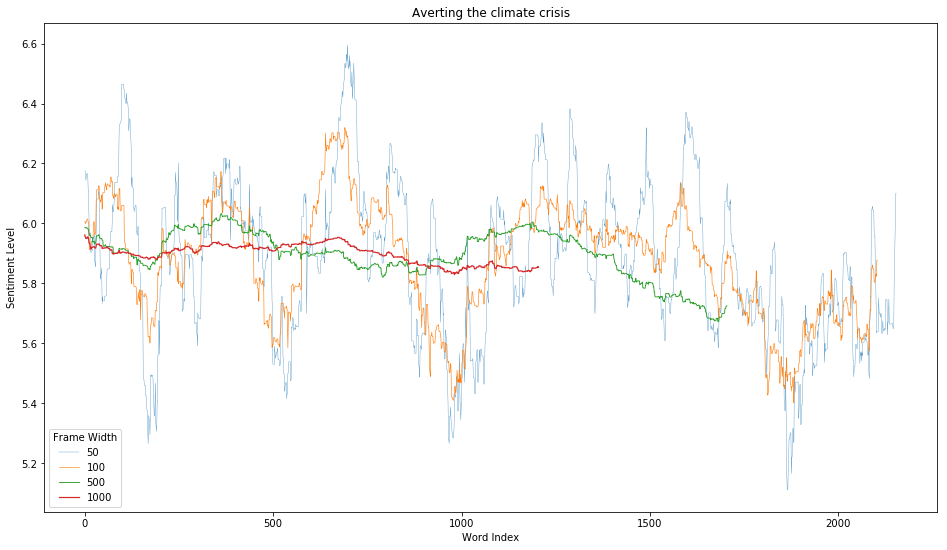

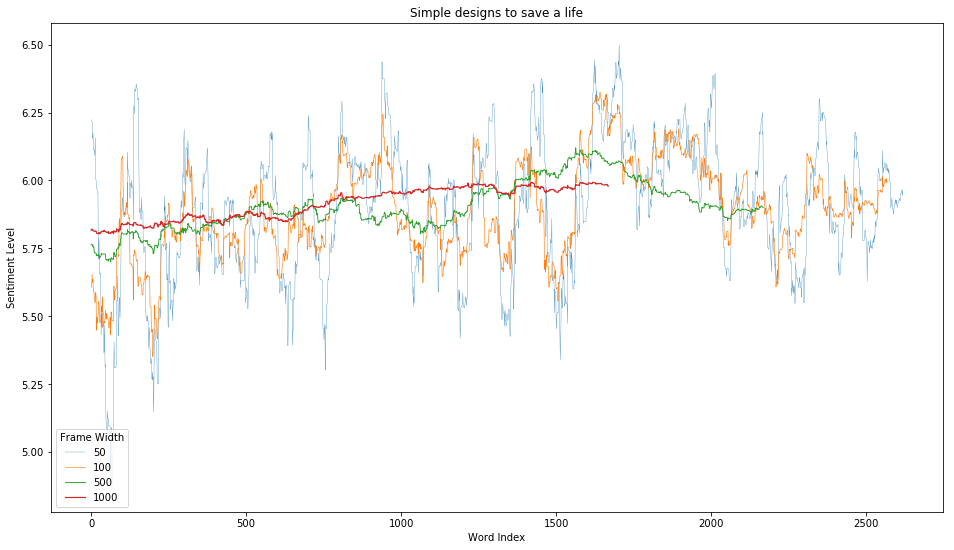

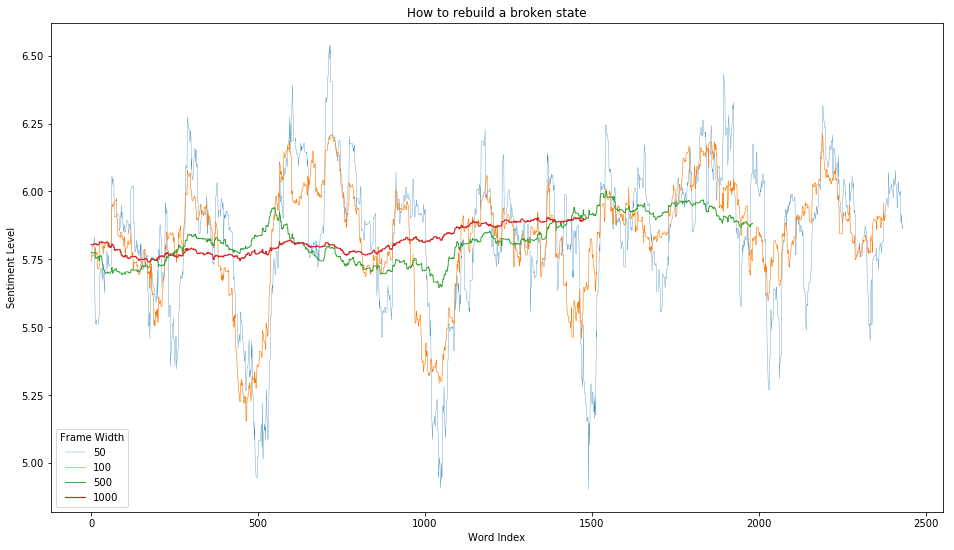

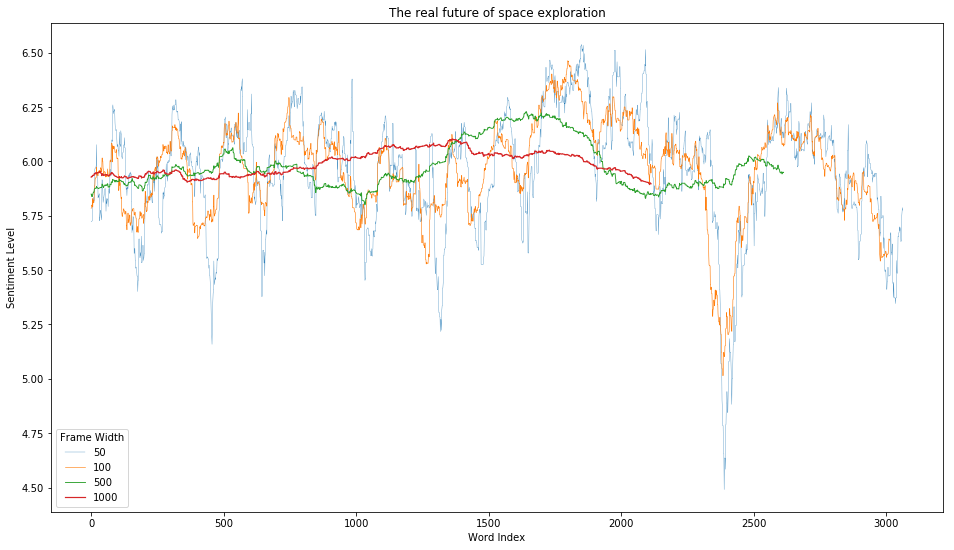

In [48]:
initial_preview = 4
for i, (talk, transcript) in enumerate(transcript_dict.items()): 
    if i == initial_preview: 
        break
    fig = plt.figure(figsize=(16, 9)) 
    axs = plt.subplot(111) 
    cnt = 1
    for frame_size in [50, 100, 500, 1000]: 
        sentil = analyze_sentiment(transcript, frame_size=frame_size, alpha=0.5)
        axs.plot(sentil[0, :], sentil[1, :], linewidth=0.3 * cnt, label=str(frame_size))
        cnt += 1
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, labels, title="Frame Width", loc=3)
    axs.set_xlabel("Word Index") 
    axs.set_ylabel("Sentiment Level")
    axs.set_title(data.loc[talk, "headline"])
    

It seems as if the window size of 200 captures most of the movements in these talks with decent accuracy. We'll go ahead with that. Now, let's test our resampling hypothesis, normalizing everything to n = 1000 - 200 + 1 = 801 data points. 

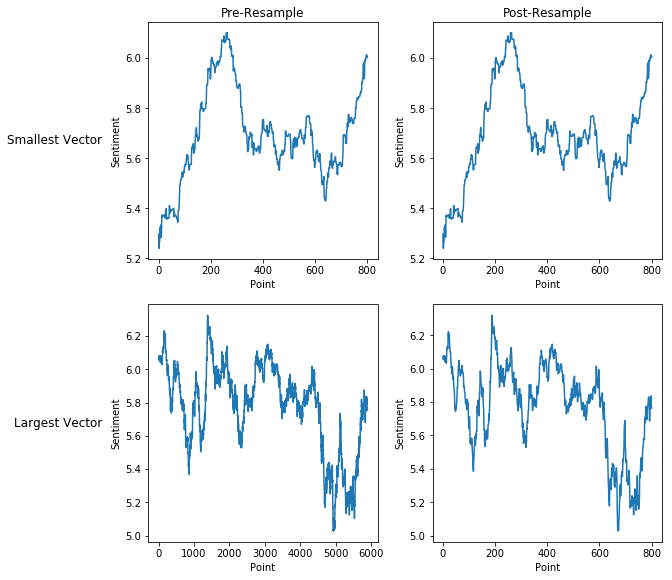

In [49]:
FRAME_SIZE = 200 
fig, axes = plt.subplots(2, 2, figsize=(8,8)) 
min_len = min(lengths) 
max_len = max(lengths)
minner = None
maxer = None 
for transcript in transcript_dict.values(): 
    if len(transcript) == min_len: 
        minner=transcript
    if len(transcript) == max_len: 
        maxer = transcript
#calculate sentiment frame size 

min_senti = analyze_sentiment(minner, frame_size=FRAME_SIZE, alpha=0.5) 
max_senti = analyze_sentiment(maxer, frame_size=FRAME_SIZE, alpha=0.5)

cols = ["Pre-Resample", "Post-Resample"] 
rows = ["Smallest Vector", "Largest Vector"] 

plt.setp(axes.flat, xlabel="Point", ylabel="Sentiment")
pad = 5
for ax, col in zip(axes[0], cols): 
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), 
                xycoords='axes fraction', 
                textcoords='offset points', 
                size='large', 
                ha='center', 
                va='baseline')
for ax, row in zip(axes[:, 0], rows): 
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), 
               xycoords=ax.yaxis.label, 
               textcoords = 'offset points', 
               size='large', 
               ha = 'right', 
               va='center')
axes[0][0].plot(min_senti[0, :], min_senti[1, :])
axes[1][0].plot(max_senti[0, :], max_senti[1, :])

#resampling number
num = 1000 - FRAME_SIZE + 1

min_sample = np.floor(np.linspace(0, min_senti.shape[1] - 1, num=num)).astype(int)
max_sample = np.floor(np.linspace(0, max_senti.shape[1] - 1, num=num)).astype(int)

xrange = np.arange(0, num) 
min_resample = min_senti[1, min_sample] 
max_resample = max_senti[1, max_sample]

axes[0][1].plot(xrange, min_resample)
axes[1][1].plot(xrange, max_resample)
fig.tight_layout()

Therefore, the shape of the plots are preserved. We can now apply this to all of the vectors, and create a two-dimensional array of shape 
[2022, 801], with each row holding the sampled vector. 

In [50]:
sampled_array = np.ndarray((len(transcript_dict.keys()), 1000 - FRAME_SIZE + 1))
dict_index_map = {} 
index_dict_map = {} 
for i, (key, value) in enumerate(transcript_dict.items()): 
    dict_index_map[key] = i 
    index_dict_map[i] = key 
    senti = analyze_sentiment(value, frame_size=FRAME_SIZE, alpha=0.5)
    #resample 
    index = np.floor(np.linspace(0, senti.shape[1] - 1, num=num)).astype(int)
    sampled_array[i, :] = senti[1, index]

Mean of Mean of All Stories 5.87000776082 σ: 0.131817736535


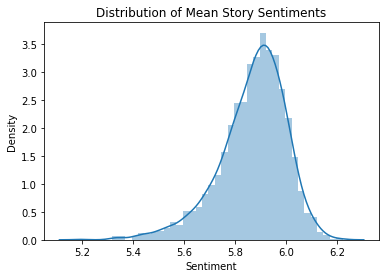

In [51]:
#Compute basic statistics
print("Mean of Mean of All Stories", np.mean(sampled_array), "σ:", sampled_array.mean(axis=1).std()) 
#basic visualization of distribution of means 
ax = sn.distplot(sampled_array.mean(axis=1))
ax.set_title("Distribution of Mean Story Sentiments")
ax.set_xlabel("Sentiment") 
ax.set_ylabel("Density") 

Means are evidently quite normal, perhaps with a slight left-skew. Now, let's actually do the cross-comparisons. First, we'll use the method in the paper \cite{story analysis} and use SVD, to identify basic arcs. 

In [52]:
from scipy.linalg import svd
U, S, Vt = svd(sampled_array, full_matrices=False)

In [53]:
#Calculate the maximal variance explained by each component (i.e. each eigenvector of the covariance matrix)  
denom = lambda m: np.sum(np.square(m))
num = lambda m: np.square(m) 
num = np.vectorize(num) 
d = denom(S) 
varexp = num(S)/d
v = varexp[0:10]*100
for i, k in enumerate(v): 
    print(i, k)

0 99.9270996305
1 0.0116085562199
2 0.0097886800534
3 0.0076906634948
4 0.00718752764363
5 0.00549606257574
6 0.00467498372427
7 0.00394781848862
8 0.00311446265945
9 0.00277435886904


The first eigenvector explains 99.9% of variance! This means that there is a very strong arc that explains all the stories. Let's look at it. 

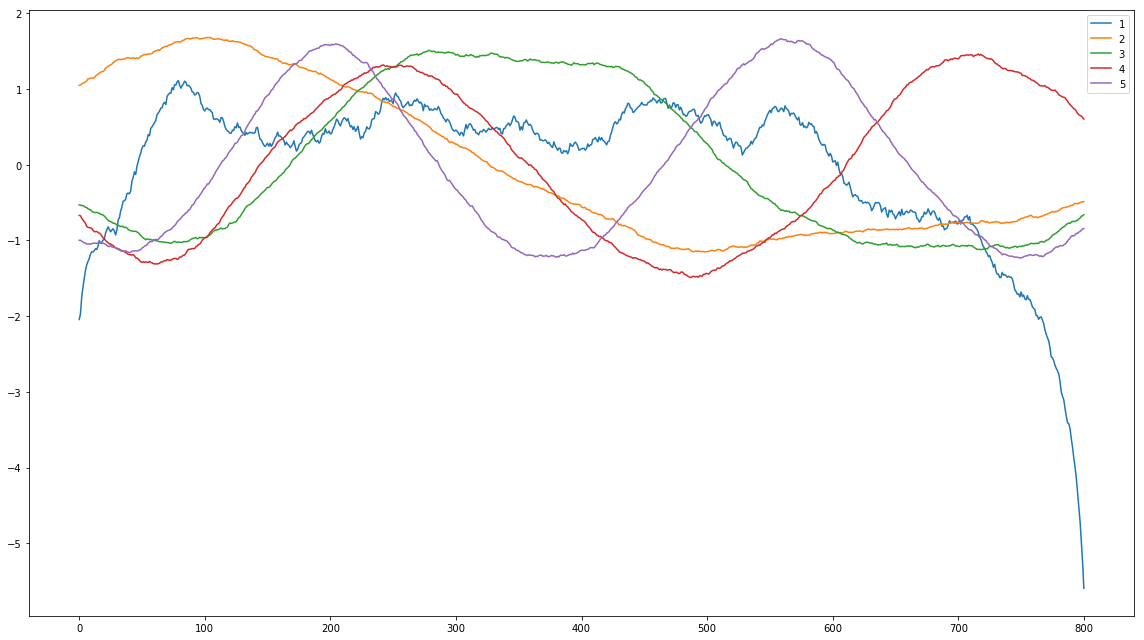

In [54]:
#Plot the first 6 singular vectors 
#we'll normalize the vectors to get an idea of shape 
fig = plt.figure(figsize=(16, 9)) 
ax = plt.subplot(111)
for i, v in enumerate(Vt[0:5, :]): 
    v -= v.mean() 
    v /= v.std() 
    ax.plot(xrange, v,label=str(i+1))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels) 
fig.tight_layout() 
fig.savefig('5vec_decomp.png', dpi=300, bbox_inches="tight")

Let's inspect these one by one. The first line contains the overall, major plotline of a TED talk: 

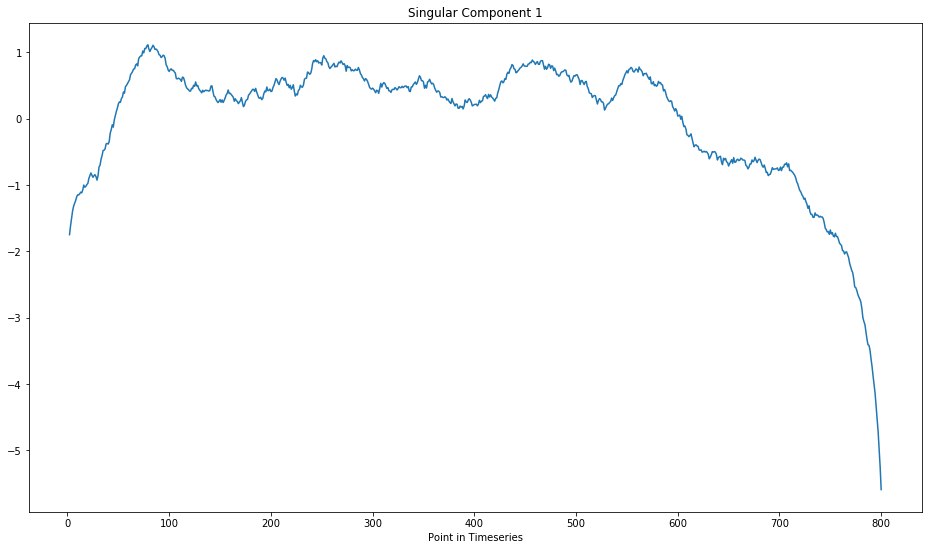

In [55]:
def quickplt(v, i):
    colorcycle = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    plt.figure(figsize=(16, 9))
    ax = plt.subplot(111) 

    mask = np.arange(2, v.shape[0]) 

    ax.plot(xrange[mask], v[mask], colorcycle[i % len(colorcycle)], label=str(i + 1))
    ax.set_title("Singular Component " + str(i + 1))
    ax.set_xlabel("Point in Timeseries")
    plt.savefig(str(i) + "SVD.png", dpi=300)
quickplt(Vt[0, :], 0)

There's a rise, a short fall, a rise, a fall, rise, and major fall. This follows a broad "Icarus" storyline: arise, then a general fall. This is the core shape of almost every ted talk. The variances are explained by the next singular components. 

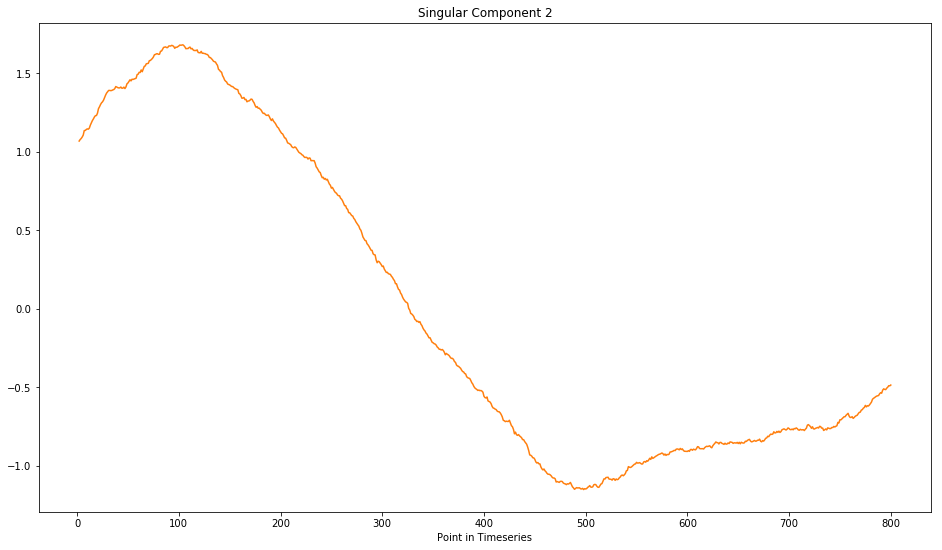

In [56]:
quickplt(Vt[1, :], 1)

The next overaly seems to be a short rise, followed by a fall. A major fall. However, this is a redeeming rise: this rise-fall-rise is a "cinderella" pattern, evident in the stories TED speakers tell when they tell of a tragedy that befell them, and then a strategy they used to recover. 

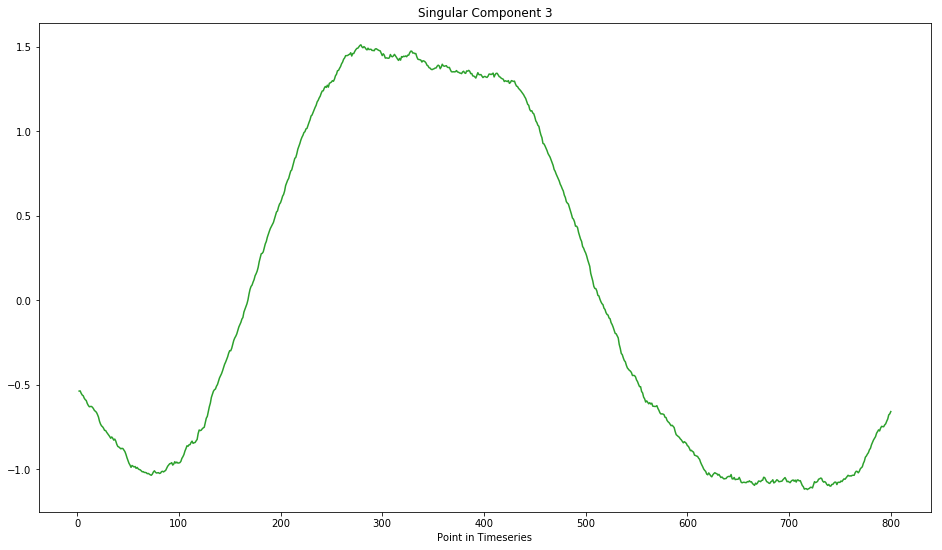

In [57]:
quickplt(Vt[2, :], 2)

3 is a "rise-fall" pattern. 

The rest devolve into sine waves, which is a replication of \cite{story}. They also discovered this in their singular values. 

## Profiles of Popular Talks 

Lets look at the profiles of the ten most popular talks, and see if we see any immediate similarities 

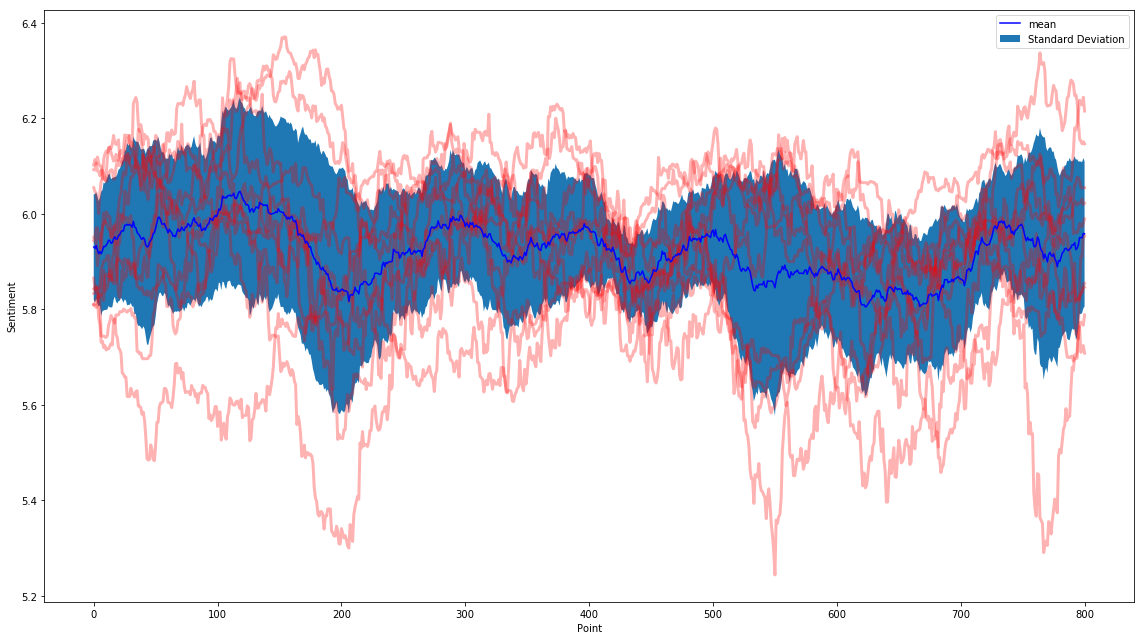

In [58]:
quickget = np.vectorize(dict_index_map.get) 
sentiments = sampled_array[quickget(data.sort_values("views", ascending=False)[0:10].index.tolist())]
#plot each of these in a composite
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111)
for i in range(0, 10): 
    ax.plot(xrange, sentiments[i, :], 'r', alpha=0.3, lw=3)
msenti = sentiments.mean(axis=0)
ax.plot(xrange, msenti, 'b', label="mean")
ax.fill_between(xrange,msenti - sentiments.std(axis=0), msenti+sentiments.std(axis=0), label="Standard Deviation")
handles, labels= ax.get_legend_handles_labels() 
ax.legend(handles, labels) 
ax.set_xlabel("Point")
ax.set_ylabel("Sentiment")
fig.tight_layout() 
fig.savefig("top10profiles.png", dpi=300)

Let's compare this mean and the SVD we found earlier. 

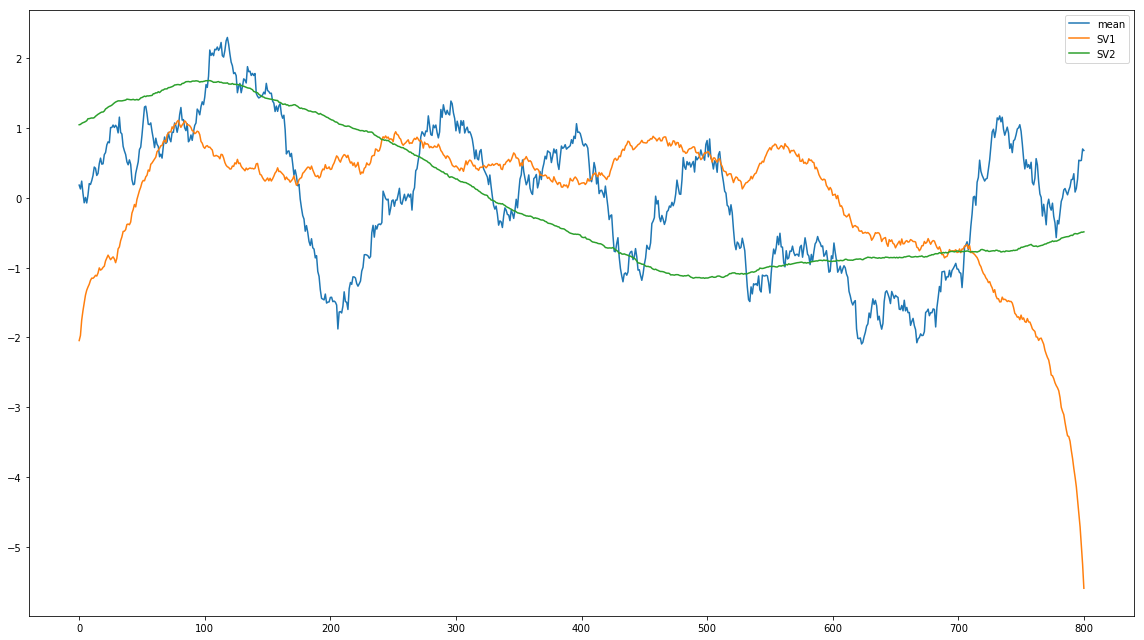

In [59]:
msenti -= msenti.mean() 
msenti /= msenti.std() 
v = Vt[0, :] 
v2 = Vt[1, :] 
v2 -= v2.mean() 
v2 /= v2.std()
v -= v.mean() 
v /= v.std()
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(111) 
ax.plot(xrange, msenti, xrange, v, xrange, v2)
ax.legend(labels=['mean', 'SV1', 'SV2'])
fig.tight_layout()
fig.savefig("2svd_and_mean.png", dpi=300)

Here, it's clear to see that the mean of the top videos follows the two strongest singular components. The general rise then fall pattern, captured by SV2, is mirrored, while the smaller bumps that SV1 has are also visible. 

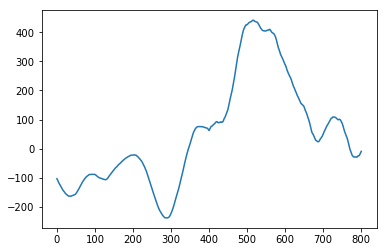

In [60]:
from scipy.signal import correlate 
plt.plot(xrange, correlate(v, msenti, mode="same"))

both indicate STRONG moments of positive correlation, especialy V2. 

In [61]:
corrcoef(msenti, v2) 

array([[ 1.        ,  0.50897168],
       [ 0.50897168,  1.        ]])

# 4. Discussion

Overall, we discovered two major features of ted talks: how tags influence a talk, and what talks look like. We managed to identify the five categories of TED Talks, which provides insight into the categories we, as humans, are interested in. We determined that there aren't any real "tag-communities" for popular talks; talks with several different tags have somewhat equal probabilities for being successful. We determined that the Cinderella storyline is apparently the most popular for talks. 

Despite the conclusions, there were some unexpected results that limited analysis: 
 - There were no communities around top tags. 
 - It was time consuming to run some calculations, such as TF-IDF. They were excluded 
 due to these time constraints 
 
There's also some future expansion left to do: 
 - Do a cross-comparison of all profiles, and create a heatmap 
 - Run TF-IDF, and correlate that with tag communities 
 - Run Node Network analysis 
 - Look at the nodes associated with communities/popular tags
 - See if any tag communities are associated with certain shapes of profiles 
 - See if popular tags are associated with certain shapes of profiles 
 
Of course, we can only reasonably identify some of the things left to do. This is a vast dataset with features we haven't even looked at yet. Who know's what it is hiding!  